<a href="https://colab.research.google.com/github/Kyriezxc/CIS522_Project/blob/Zhiyu_experiments/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/CIS522_Project"

/content/drive/MyDrive/Colab Notebooks/CIS522_Project


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

seed = 2023
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train = pd.read_csv("data/train.csv")

# Filter missing data and useless columns
train = train[train["MISSING_DATA"] == False]
train = train[train["POLYLINE"].map(len) > 200]
train = train[["POLYLINE"]]
# Choose 200000 rows randomly from dataset to run
train_1 = train.sample(200000, random_state=2023)

train

,POLYLINE
0,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."
...,...
1710663,"[[-8.60697,41.162283],[-8.60697,41.16231],[-8...."
1710665,"[[-8.612469,41.14602],[-8.612487,41.145993],[-..."
1710666,"[[-8.610138,41.140845],[-8.610174,41.140935],[..."
1710668,"[[-8.630712,41.154885],[-8.63073,41.154813],[-..."


# Pre-processing

In [5]:
def _change_type(polyline):
    polyline = polyline[2:-2]
    cords_raw = polyline.split("],[")
    cords = []
    max_lon, min_lon, max_lat, min_lat = np.float32("-inf"), np.float32("inf"), np.float32("-inf"), np.float32("inf")
    for cord in cords_raw:
        cords.append([np.float32(loc) for loc in cord.split(",")])
        max_lon = max(max_lon, cords[-1][0])
        min_lon = min(min_lon, cords[-1][0])
        max_lat = max(max_lat, cords[-1][1])
        min_lat = min(min_lat, cords[-1][1])
    return pd.Series({"POLYLINE": cords, "max_lon": max_lon, "min_lon": min_lon, "max_lat": max_lat, "min_lat": min_lat})

In [6]:
def filter_map(train, max_lat, min_lat, max_lon, min_lon):
    train.reset_index(drop=True, inplace=True)
    return train[(train["max_lat"] <= max_lat) & (train["min_lat"] >= min_lat) &
                 (train["max_lon"] <= max_lon) & (train["min_lon"] >= min_lon)]

In [7]:
def _normalize(polyline, max_lon, min_lon, max_lat, min_lat, m):
    last = polyline.pop()
    last = [(last[0]-min_lon)/(max_lon-min_lon), (last[1] - min_lat) / (max_lat - min_lat)]
    final = []
    for cord in polyline:
        normalized = [(cord[0]-min_lon)/(max_lon-min_lon), (cord[1] - min_lat) / (max_lat - min_lat)]
        normalized[0] = min(m - 1, int(normalized[0] * m))
        normalized[1] = min(m - 1, int(normalized[1] * m))
        final.append(normalized)
    return pd.Series({"POLYLINE_INIT": final, "POLYLINE_DEST": last})

In [8]:
def _to_matrix(polyline, m, activation=lambda x: x):
    mat = np.zeros((m, m), dtype=np.float32)
    n = len(polyline)
    for i in range(n):
        x = polyline[i][0]
        y = polyline[i][1]
        mat[y][x] = activation((i + 1) / n)
    return mat

In [9]:
def transform(df_train, m):
    # Change type
    changed = df_train["POLYLINE"].apply(_change_type)
    # Filter map for max/min long/lat
    changed = filter_map(changed, 41.2, 41.1, -8.6, -8.7)  #previous (41.2,41,,)
    # Get min-max
    max_longitude = changed["max_lon"].max()
    min_longitude = changed["min_lon"].min()
    max_latitude = changed["max_lat"].max()
    min_latitude = changed["min_lat"].min()
    # Normalize min-max and split
    cleaned = changed["POLYLINE"].apply(_normalize, args=(max_longitude, min_longitude, max_latitude, min_latitude, m))
    # Transform to matrices
    cleaned["MATRIX_LIN"] = cleaned["POLYLINE_INIT"].apply(_to_matrix, args=(m,))
    cleaned["MATRIX_EXP"] = cleaned["POLYLINE_INIT"].apply(_to_matrix, args=(m, lambda x: np.exp(x) - 1))
    cleaned["MATRIX_CON"] = cleaned["POLYLINE_INIT"].apply(_to_matrix, args=(m, lambda x: 1))
    return cleaned

In [10]:
transformed = transform(train_1, 40)
len(transformed)

113393

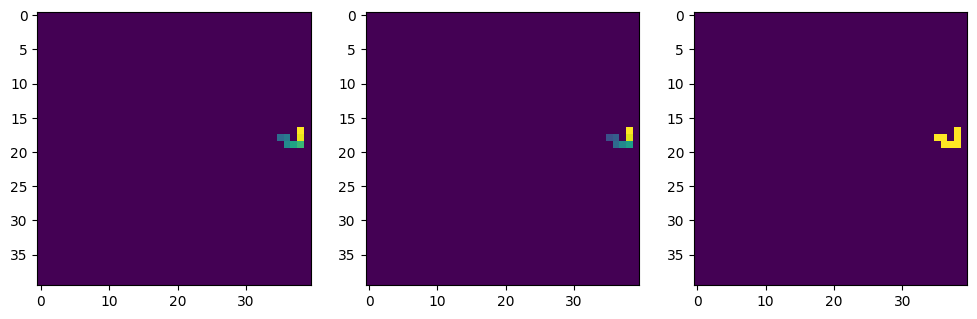

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(transformed["MATRIX_LIN"].iloc[100])
plt.subplot(1, 3, 2)
plt.imshow(transformed["MATRIX_EXP"].iloc[100])
plt.subplot(1, 3, 3)
plt.imshow(transformed["MATRIX_CON"].iloc[100])
plt.show()

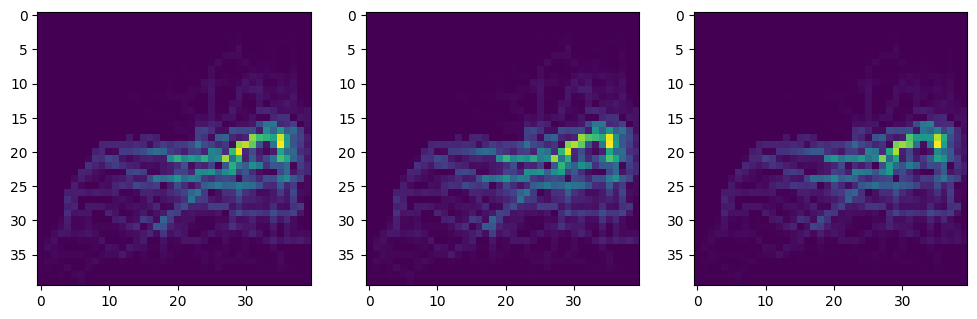

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(transformed["MATRIX_LIN"].mean())
plt.subplot(1, 3, 2)
plt.imshow(transformed["MATRIX_EXP"].mean())
plt.subplot(1, 3, 3)
plt.imshow(transformed["MATRIX_CON"].mean())
plt.show()

In [13]:
transformed.head()

,POLYLINE_INIT,POLYLINE_DEST,MATRIX_LIN,MATRIX_EXP,MATRIX_CON
0,"[[23, 24], [23, 24], [24, 24], [24, 25], [24, ...","[0.58517873, 0.60275644]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,"[[33, 18], [34, 18], [34, 18], [35, 18], [35, ...","[0.9061817, 0.5489253]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,"[[8, 23], [8, 23], [8, 23], [8, 23], [8, 23], ...","[0.5198122, 0.54251134]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,"[[35, 18], [35, 18], [35, 18], [35, 17], [35, ...","[0.5925636, 0.611881]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,"[[31, 24], [31, 24], [31, 23], [31, 23], [32, ...","[0.80029386, 0.4682167]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


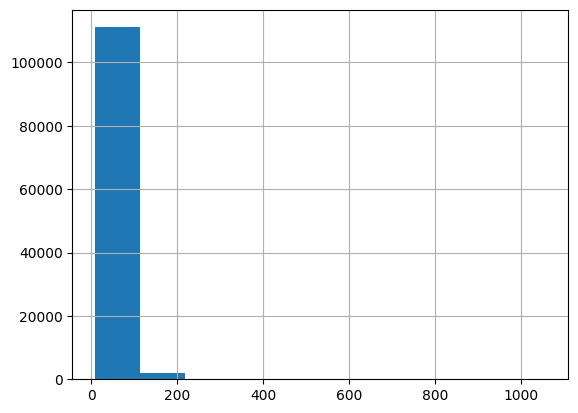

In [14]:
transformed["POLYLINE_INIT"].map(len).hist()
plt.show()

# Model Experiments

In [15]:
def sequence2tensor(sequence, seqlen=200):
    if len(sequence) > seqlen:
        sequence = sequence[-seqlen:]
    tensor = torch.zeros(seqlen, 3, dtype=torch.float32)
    for i, point in enumerate(sequence, start=seqlen-len(sequence)):
        tensor[i, :2] = torch.Tensor(point)
        tensor[i, 2] = 1  # 1 for in the sequence, 0 for out of the sequence
    return tensor

def matrix2tensor(matrix):
    return torch.Tensor(matrix)

def output2tensor(output):
    return torch.Tensor(output)

In [16]:
sequence_tensor = transformed["POLYLINE_INIT"].apply(sequence2tensor).values
matrix_tensor = transformed["MATRIX_LIN"].apply(matrix2tensor).values
output_tensor = transformed["POLYLINE_DEST"].apply(output2tensor).values

In [17]:
idx_train, idx_test = train_test_split(range(len(transformed)), test_size=0.4, random_state=2023)
idx_valid, idx_test = train_test_split(idx_test, test_size=0.5, random_state=2023)

seq_train, seq_valid = sequence_tensor[idx_train], sequence_tensor[idx_valid]
mat_train, mat_valid = matrix_tensor[idx_train], matrix_tensor[idx_valid]
out_train, out_valid = output_tensor[idx_train], output_tensor[idx_valid]

In [18]:
def train_model(model, criterion, train_loader, valid_loader, learning_rate=0.001, epochs=20, device=DEVICE):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, valid_losses = [], []
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = []
        for in_, out in train_loader:
            in_, out = in_.to(device), out.to(device)
            optimizer.zero_grad()
            pred = model(in_)
            loss = criterion(pred, out)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_losses.append(np.mean(train_loss))
        model.eval()
        valid_loss = []
        for in_, out in valid_loader:
            in_, out = in_.to(device), out.to(device)
            pred = model(in_)
            loss = criterion(pred, out)
            valid_loss.append(loss.item())
        valid_losses.append(np.mean(valid_loss))
    print("Last epoch train loss: {}".format(train_losses[-1]))
    print("Last epoch validation loss: {}".format(valid_losses[-1]))
    plt.figure()
    plt.plot(train_losses, color="blue")
    plt.plot(valid_losses, color="red")
    plt.show()

## LSTM

In [19]:
class SequenceDataset(Dataset):
    def __init__(self, sequence, output):
        self.sequence = sequence
        self.output = output

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, idx):
        return self.sequence[idx], self.output[idx]

In [20]:
train_data = SequenceDataset(seq_train, out_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

valid_data = SequenceDataset(seq_valid, out_valid)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

In [23]:
class LSTM(nn.Module):
    def __init__(self, i_size=3, h_size=6, n_layers=1, o_size=2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size = i_size,
            hidden_size = h_size,
            num_layers = n_layers,
            bias = False,
            batch_first = True
        )
        self.out = nn.Linear(h_size, o_size)
        
    def forward(self, x):
        out, (h, c) = self.lstm(x, None)  # None represents zero initial hidden state
        return torch.sigmoid(self.out(out[:, -1, :]))  # choose last time step of output

  0%|          | 0/20 [00:00<?, ?it/s]

Last epoch train loss: 8.667929682986113e-05
Last epoch validation loss: 8.686994799678411e-05


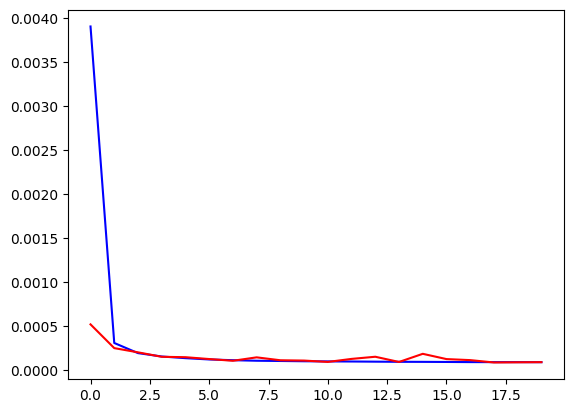

In [24]:
lstm = LSTM(3, 6, 1, 2)
train_model(lstm, torch.nn.HuberLoss(), train_loader, valid_loader, learning_rate=0.002)

  0%|          | 0/20 [00:00<?, ?it/s]

Last epoch train loss: 0.00016517931461427558
Last epoch validation loss: 0.00018169036455629526


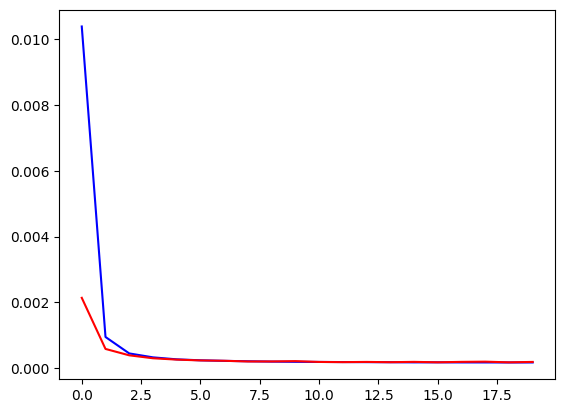

In [25]:
lstm = LSTM(3, 6, 1, 2)
train_model(lstm, nn.MSELoss(), train_loader, valid_loader, learning_rate=0.001)

## MLP with matrix input

In [26]:
class MatrixDataset(Dataset):
    def __init__(self, matrix, output):
        self.matrix = matrix
        self.output = output

    def __len__(self):
        return len(self.matrix)

    def __getitem__(self, idx):
        return self.matrix[idx], self.output[idx]

In [27]:
train_data = MatrixDataset(mat_train, out_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

valid_data = MatrixDataset(mat_valid, out_valid)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

In [28]:
class MLP(nn.Module):
    def __init__(self, i_size=40*40, h_size=100, h_layers=2, o_size=2):
        super(MLP, self).__init__()
        self.hiddens = nn.Sequential()
        self.hiddens.append(nn.Sequential(nn.Linear(i_size, h_size), nn.Dropout(), nn.ReLU()))
        for i in range(1, h_layers):
            self.hiddens.append(nn.Sequential(nn.Linear(h_size, h_size), nn.Dropout(), nn.ReLU()))
        self.out = nn.Linear(h_size, o_size)
        
    def forward(self, x):
        x = x.flatten(1)
        for hidden in self.hiddens:
            x = hidden(x)
        return torch.sigmoid(self.out(x))

  0%|          | 0/20 [00:00<?, ?it/s]

Last epoch train loss: 0.0351289646048799
Last epoch validation loss: 0.020957055693151247


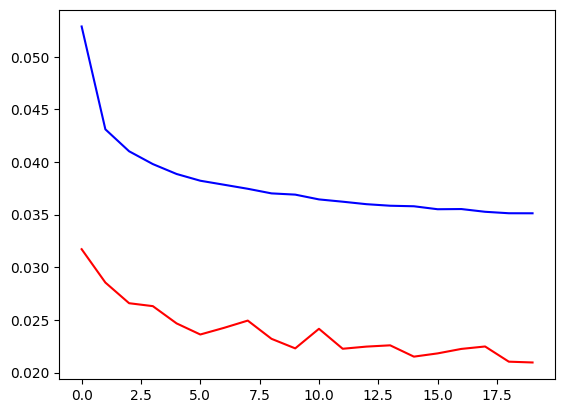

In [29]:
mlp = MLP()
train_model(mlp, nn.L1Loss(), train_loader, valid_loader, learning_rate=0.002)

  0%|          | 0/20 [00:00<?, ?it/s]

Last epoch train loss: 0.002299994967494482
Last epoch validation loss: 0.0012179211348550998


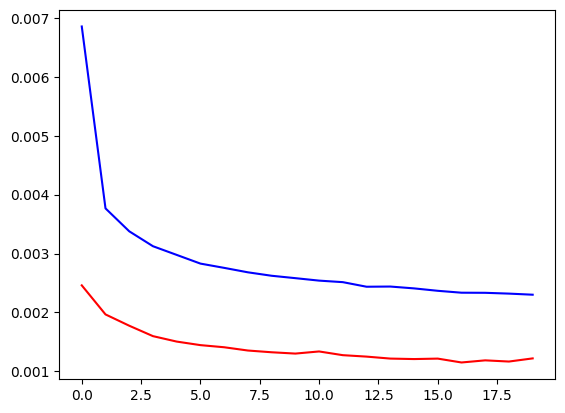

In [30]:
mlp = MLP()
train_model(mlp, nn.MSELoss(), train_loader, valid_loader, learning_rate=0.001)

## CNN

In [32]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        #self.conv2 = nn.Conv2d(32, 64, 3, 1)
        #self.fc1 = nn.Linear(20736, 128)
        #self.fc1 = nn.Linear(82944, 128)
        self.fc1 = nn.Linear(46208, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = nn.functional.relu(x)
        #x = self.conv2(x)
        #x = F.relu(x)
        #x = F.max_pool2d(x, 2)
        #print(x.shape)
        x = torch.flatten(x, 1)
        #print(x.shape)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        #print(x.shape)
        return torch.sigmoid(x)

  0%|          | 0/30 [00:00<?, ?it/s]

Last epoch train loss: 0.0068298677162834465
Last epoch validation loss: 0.010041383774557584


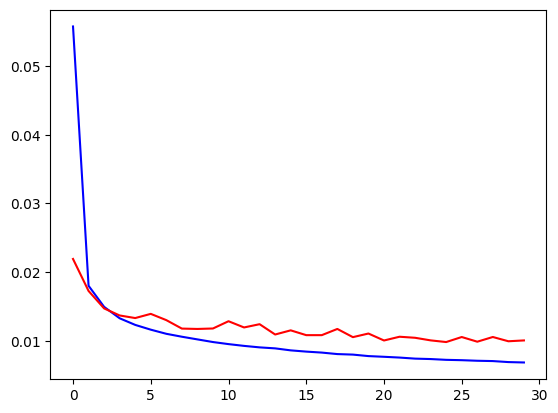

In [33]:
cnn = CNN()
train_model(cnn, nn.L1Loss(), train_loader, valid_loader, learning_rate=0.001, epochs=30)

  0%|          | 0/20 [00:00<?, ?it/s]

Last epoch train loss: 0.00015264005475516495
Last epoch validation loss: 0.0003744921285468875


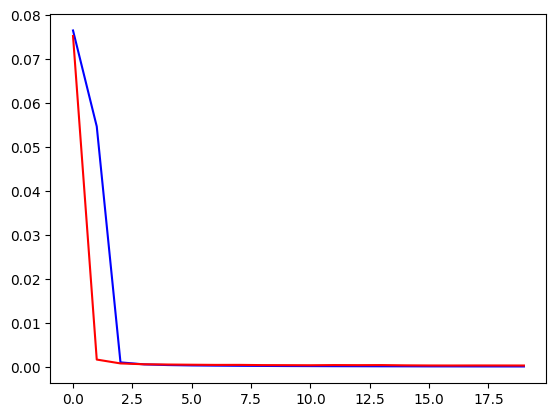

In [34]:
cnn = CNN()
train_model(cnn, nn.MSELoss(), train_loader, valid_loader, learning_rate=0.001)

## SWin with matrix input

In [35]:
!pip install timm > /dev/null

In [36]:
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class SwinMLPBlock(nn.Module):
    r""" Swin MLP Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        drop (float, optional): Dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=2, shift_size=0,
                 mlp_ratio=4., drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.padding = [self.window_size - self.shift_size, self.shift_size,
                        self.window_size - self.shift_size, self.shift_size]  # P_l,P_r,P_t,P_b

        self.norm1 = norm_layer(dim)
        # use group convolution to implement multi-head MLP
        self.spatial_mlp = nn.Conv1d(self.num_heads * self.window_size ** 2,
                                     self.num_heads * self.window_size ** 2,
                                     kernel_size=1,
                                     groups=self.num_heads)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # shift
        if self.shift_size > 0:
            P_l, P_r, P_t, P_b = self.padding
            shifted_x = F.pad(x, [0, 0, P_l, P_r, P_t, P_b], "constant", 0)
        else:
            shifted_x = x
        _, _H, _W, _ = shifted_x.shape

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # Window/Shifted-Window Spatial MLP
        x_windows_heads = x_windows.view(-1, self.window_size * self.window_size, self.num_heads, C // self.num_heads)
        x_windows_heads = x_windows_heads.transpose(1, 2)  # nW*B, nH, window_size*window_size, C//nH
        x_windows_heads = x_windows_heads.reshape(-1, self.num_heads * self.window_size * self.window_size,
                                                  C // self.num_heads)
        spatial_mlp_windows = self.spatial_mlp(x_windows_heads)  # nW*B, nH*window_size*window_size, C//nH
        spatial_mlp_windows = spatial_mlp_windows.view(-1, self.num_heads, self.window_size * self.window_size,
                                                       C // self.num_heads).transpose(1, 2)
        spatial_mlp_windows = spatial_mlp_windows.reshape(-1, self.window_size * self.window_size, C)

        # merge windows
        spatial_mlp_windows = spatial_mlp_windows.reshape(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(spatial_mlp_windows, self.window_size, _H, _W)  # B H' W' C

        # reverse shift
        if self.shift_size > 0:
            P_l, P_r, P_t, P_b = self.padding
            x = shifted_x[:, P_t:-P_b, P_l:-P_r, :].contiguous()
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x



class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x


class BasicLayer(nn.Module):
    """ A basic Swin MLP layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        drop (float, optional): Dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., drop=0., drop_path=0.,
                 norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinMLPBlock(dim=dim, input_resolution=input_resolution,
                         num_heads=num_heads, window_size=window_size,
                         shift_size=0,
                         mlp_ratio=mlp_ratio,
                         drop=drop,
                         drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                         norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x






class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=40, patch_size=10, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x


class SwinMLP(nn.Module):
    r""" Swin MLP
    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin MLP layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        drop_rate (float): Dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=40, patch_size=10, in_chans=1, num_classes=2,
                 embed_dim=96, depths=[4,1,1], num_heads=[4,8,12],
                 window_size=2, mlp_ratio=4., drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=False,
                 use_checkpoint=False, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               drop=drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveMaxPool1d(1)
        #self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Linear, nn.Conv1d)):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


    def forward_features(self, x):
        x = self.patch_embed(x)
        #print(x.shape)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)
        #print(x.shape)
        for layer in self.layers:
            x = layer(x)
       
        #x = self.norm(x)  # B L C
        #print(x.shape)
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        #print(x.shape)
        x = torch.flatten(x, 1)
        #print(x.shape)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x



In [37]:
class PetNet_(nn.Module):
    def __init__(self, model_name='swin_tiny_patch4_window7_224', pretrained=False, m = 40):
        super().__init__()
        self.model = SwinMLP()
        # Replaced the final head layers in model with our own Linear layer
        num_features = self.model.head.in_features
        #self.model.head = nn.Linear(num_features, 128)
        self.fully_connect = nn.Sequential(nn.Linear(128, 64),
                                           nn.ReLU(),
                                           nn.Linear(64, 2)
                                          )
        self.dropout = nn.Dropout(p=0.5)
        self.proj = nn.Linear(m*m,224*224)
        self.ac1 = nn.ReLU()
    
    def forward(self, x):
        #x = x.reshape(x.shape[0],1,-1)
        #x = self.proj(x)
        #x = self.ac1(x)
        x = x.reshape(x.shape[0],1,40,40)

        #print(x.shape)
        x = self.model(x)
        #print(x.shape)
        #print(x.shape)
        # Using dropout functions to randomly shutdown some of the nodes in hidden layers to prevent overfitting.
        #x = self.dropout(x)
        # Concatenate the metadata into the results.
        #x = torch.cat([x, features], dim=1)
        #output = self.fully_connect(x)
        return torch.sigmoid(x)

  0%|          | 0/50 [00:00<?, ?it/s]

Last epoch train loss: 7.136038484224314e-05
Last epoch validation loss: 0.00014764219248859198


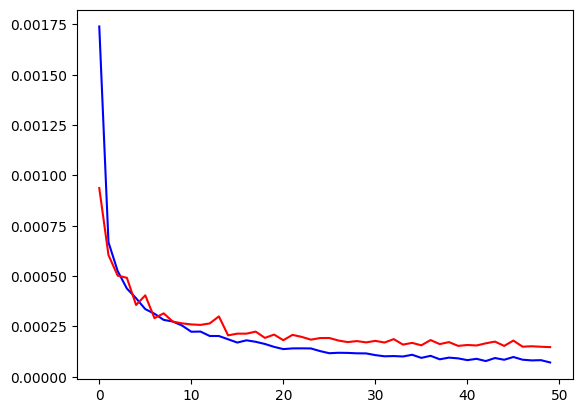

In [39]:
swin = PetNet_()
train_model(swin, torch.nn.HuberLoss(), train_loader, valid_loader, learning_rate=0.0002, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Last epoch train loss: 0.00016136709635425621
Last epoch validation loss: 0.0003554357762791177


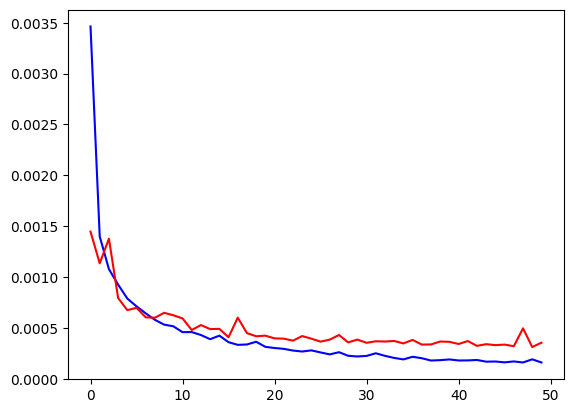

In [40]:
swin = PetNet_()
train_model(swin, nn.MSELoss(), train_loader, valid_loader, learning_rate=0.0002, epochs=50)

## Matrix input with exponential activation

In [41]:
matrix_tensor = transformed["MATRIX_EXP"].apply(matrix2tensor).values
mat_train, mat_valid = matrix_tensor[idx_train], matrix_tensor[idx_valid]

In [42]:
train_data = MatrixDataset(mat_train, out_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

valid_data = MatrixDataset(mat_valid, out_valid)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Last epoch train loss: 0.03434537538621379
Last epoch validation loss: 0.020678041287710967


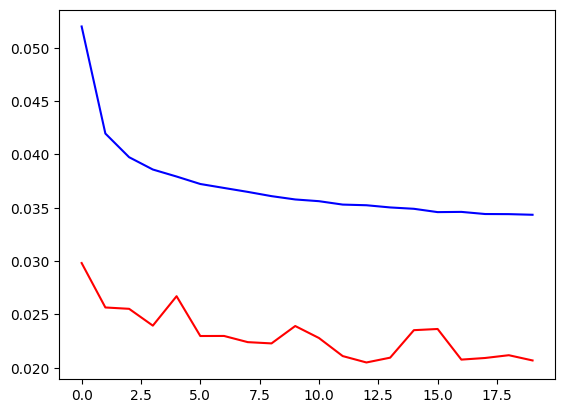

In [43]:
mlp = MLP()
train_model(mlp, nn.L1Loss(), train_loader, valid_loader, learning_rate=0.002)

  0%|          | 0/20 [00:00<?, ?it/s]

Last epoch train loss: 0.002129221938875866
Last epoch validation loss: 0.0010447147252320142


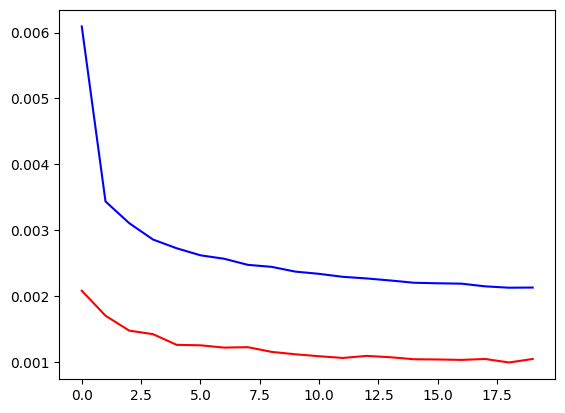

In [44]:
mlp = MLP()
train_model(mlp, nn.MSELoss(), train_loader, valid_loader, learning_rate=0.001)

  0%|          | 0/30 [00:00<?, ?it/s]

Last epoch train loss: 0.006429433816067062
Last epoch validation loss: 0.00910826652691188


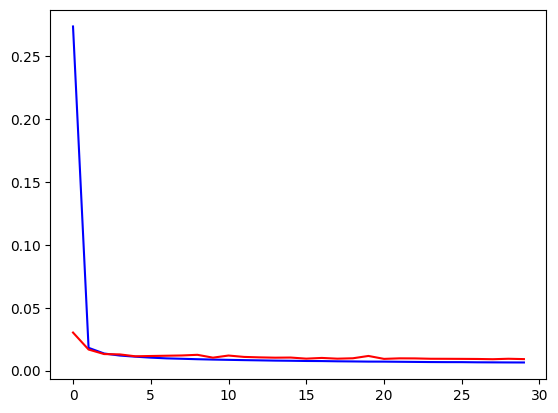

In [45]:
cnn = CNN()
train_model(cnn, nn.L1Loss(), train_loader, valid_loader, learning_rate=0.001, epochs=30)

  0%|          | 0/20 [00:00<?, ?it/s]

Last epoch train loss: 0.00013480277360721992
Last epoch validation loss: 0.00031409261485440396


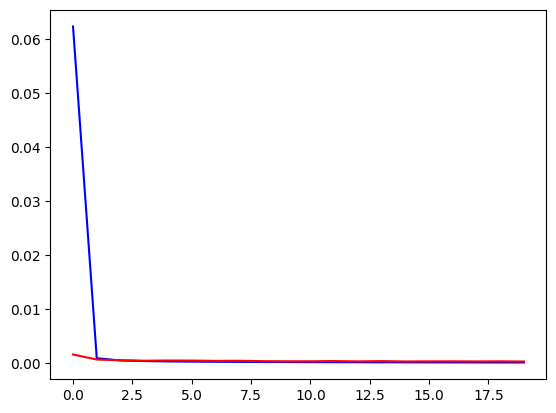

In [46]:
cnn = CNN()
train_model(cnn, nn.MSELoss(), train_loader, valid_loader, learning_rate=0.001)

  0%|          | 0/50 [00:00<?, ?it/s]

Last epoch train loss: 8.218115857730448e-05
Last epoch validation loss: 0.00013766674011081627


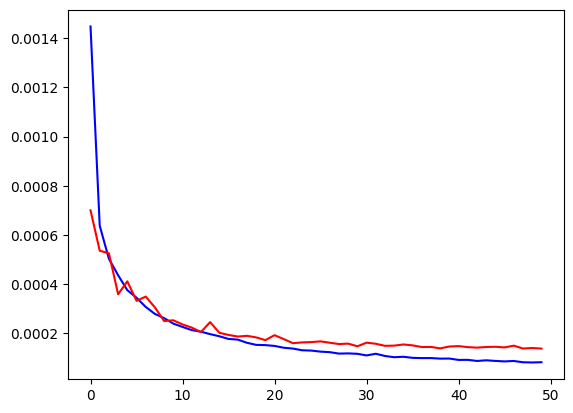

In [49]:
swin1 = PetNet_()
train_model(swin1, nn.SmoothL1Loss(), train_loader, valid_loader, learning_rate=0.0001, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Last epoch train loss: 0.00012894597110308203
Last epoch validation loss: 0.0002569367873816895


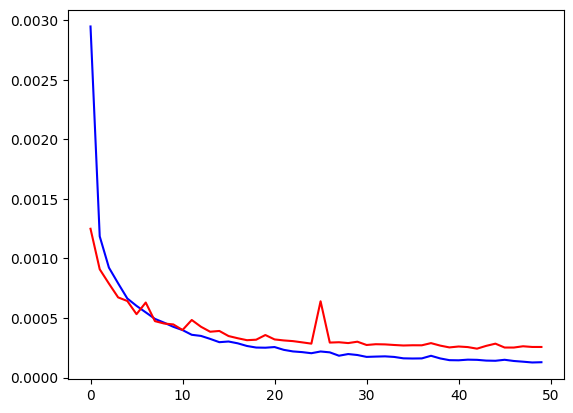

In [48]:
swin2 = PetNet_()
train_model(swin2, nn.MSELoss(), train_loader, valid_loader, learning_rate=0.0002, epochs=50)

# Save Model

In [50]:
torch.save(swin1, "swin.model")

In [51]:
from torchsummary import summary

summary(swin1, (40, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 96, 4, 4]           9,696
        PatchEmbed-2               [-1, 16, 96]               0
           Dropout-3               [-1, 16, 96]               0
         LayerNorm-4               [-1, 16, 96]             192
            Conv1d-5               [-1, 16, 24]              80
          Identity-6               [-1, 16, 96]               0
         LayerNorm-7               [-1, 16, 96]             192
            Linear-8              [-1, 16, 384]          37,248
              GELU-9              [-1, 16, 384]               0
          Dropout-10              [-1, 16, 384]               0
           Linear-11               [-1, 16, 96]          36,960
          Dropout-12               [-1, 16, 96]               0
              Mlp-13               [-1, 16, 96]               0
         Identity-14               [-1,

In [53]:
final_model = torch.load("swin.model")
final_model = final_model.to(DEVICE)

In [57]:
mat_test = matrix_tensor[idx_test]
out_test = matrix_tensor[idx_test]

test_data = MatrixDataset(mat_test, out_test)
test_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

test_loss = 0
criterion = nn.SmoothL1Loss(reduction="sum")
for in_, out in test_loader:
    in_, out = in_.to(DEVICE), out.to(DEVICE)
    pred = final_model(in_)
    loss = criterion(pred, out)
    test_loss += loss.item()
print("Test loss: {}".format(test_loss / len(mat_test)))

Test loss: 0.000275302951873105
